In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.neo_finrl.env_stock_trading.env_stocktrading_np import StockTradingEnv as StockTradingEnv_numpy
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.drl_agents.rllib.models import DRLAgent as DRLAgent_rllib
from finrl.neo_finrl.data_processor import DataProcessor


from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import ray
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/home/hcaoaf/.local/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [8]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [9]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [10]:
# from config.py end_date is a string
config.END_DATE

'2021-10-31'

In [11]:
print(config.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [12]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-07-06',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [13]:
print(df.shape)

(91870, 8)


In [14]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2008-12-31,3.070357,3.133571,3.047857,2.617247,607541200,AAPL,2
1,2008-12-31,57.110001,58.220001,57.060001,45.031921,6287200,AMGN,2
2,2008-12-31,17.969999,18.750000,17.910000,14.988303,9625600,AXP,2
3,2008-12-31,41.590000,43.049999,41.500000,32.005882,5443100,BA,2
4,2008-12-31,43.700001,45.099998,43.700001,30.925051,6277400,CAT,2


# Preprocess Data

In [15]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list= config.TECHNICAL_INDICATORS_LIST, 
    use_vix=True,
    use_turbulence=True,
    user_defined_feature=False
)
processed_full = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3148, 8)
Successfully added vix
Successfully added turbulence index


In [17]:
processed_full.sort_values(['date','tic'], ignore_index=True).head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2008-12-31,3.070357,3.133571,3.047857,2.617247,607541200,AAPL,2,0.0,2.934221,2.465863,100.0,66.666667,100.0,2.617247,2.617247,40.0,0.0
1,2008-12-31,57.110001,58.220001,57.060001,45.031921,6287200,AMGN,2,0.0,2.934221,2.465863,100.0,66.666667,100.0,45.031921,45.031921,40.0,0.0
2,2008-12-31,17.969999,18.750000,17.910000,14.988303,9625600,AXP,2,0.0,2.934221,2.465863,100.0,66.666667,100.0,14.988303,14.988303,40.0,0.0
3,2008-12-31,41.590000,43.049999,41.500000,32.005882,5443100,BA,2,0.0,2.934221,2.465863,100.0,66.666667,100.0,32.005882,32.005882,40.0,0.0
4,2008-12-31,43.700001,45.099998,43.700001,30.925051,6277400,CAT,2,0.0,2.934221,2.465863,100.0,66.666667,100.0,30.925051,30.925051,40.0,0.0


# Design Env

In [20]:
train = data_split(processed_full, start='2009-01-01', end='2020-07-01')
trade = data_split(processed_full, start='2020-07-01', end='2021-07-06')
print(len(train), len(trade))

83897 7337


In [21]:
train.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,2020-06-30,288.570007,296.450012,287.660004,289.569794,2932900,UNH,1,-0.019594,305.819443,272.941272,52.413055,-25.789617,1.846804,289.815175,282.752200,30.43,12.918763
2892,2020-06-30,191.490005,193.750000,190.160004,191.749405,9040100,V,1,1.054351,199.805212,186.023337,53.021034,-51.499707,2.013358,192.501170,182.641773,30.43,12.918763
2892,2020-06-30,54.919998,55.290001,54.360001,51.604496,17414800,VZ,1,-0.447764,55.232497,49.916929,48.097038,-50.926671,8.508886,52.255363,52.718949,30.43,12.918763
2892,2020-06-30,42.119999,42.580002,41.759998,40.278061,4782100,WBA,1,-0.086659,43.965359,37.648309,48.830189,-14.417124,1.500723,40.380679,40.174252,30.43,12.918763
2892,2020-06-30,119.220001,120.129997,118.540001,117.465683,6836400,WMT,1,-0.896830,120.856459,114.824141,48.159678,-69.901646,3.847271,119.150814,121.108864,30.43,12.918763


In [22]:
trade.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,91.279999,91.839996,90.977501,90.282990,110737200,AAPL,2,3.027292,93.089461,80.517397,62.807151,107.485317,29.730532,84.287016,78.044629,28.620001,53.068235
0,2020-07-01,235.520004,256.230011,232.580002,246.209015,6575800,AMGN,2,3.728078,238.256911,205.260966,61.279631,271.963432,46.806139,220.275946,221.376005,28.620001,53.068235
0,2020-07-01,95.250000,96.959999,93.639999,92.579544,3301000,AXP,2,-0.391247,111.015320,88.229327,48.504814,-66.339690,3.142448,97.765431,91.181246,28.620001,53.068235
0,2020-07-01,185.880005,190.610001,180.039993,180.320007,49036700,BA,2,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068235
0,2020-07-01,129.380005,129.399994,125.879997,121.818474,2807800,CAT,2,1.284937,131.887574,114.449383,52.865417,35.546891,14.457404,120.567699,114.745773,28.620001,53.068235


In [23]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [24]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [25]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
}

# build gym
e_train_gym = StockTradingEnv(df=train, **env_kwargs)

In [26]:
# environment for training
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Implement DRL Algorithms

In [27]:
agent = DRLAgent(env = env_train)

## Model1: A2C

In [28]:
model_a2c = agent.get_model(model_name='a2c')

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [29]:
training_a2c = agent.train_model(
    model=model_a2c,
    tb_log_name='a2c',
    total_timesteps=50000
)

Logging to tensorboard_log/a2c/a2c_1
---------------------------------------
| time/                 |             |
|    fps                | 107         |
|    iterations         | 100         |
|    time_elapsed       | 4           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.3       |
|    explained_variance | -0.22       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 25.5        |
|    reward             | -0.23112771 |
|    std                | 1           |
|    value_loss         | 0.47        |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 112         |
|    iterations         | 200         |
|    time_elapsed       | 8           |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -41.3       |
|  

## Model2: DDPG

In [30]:
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [31]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

Logging to tensorboard_log/ddpg/ddpg_1
day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3880195.42
total_reward: 2880195.42
total_cost: 5213.92
total_trades: 40421
Sharpe: 0.690
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 71       |
|    time_elapsed    | 162      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | -23.9    |
|    critic_loss     | 1.84e+03 |
|    learning_rate   | 0.001    |
|    n_updates       | 8679     |
|    reward          | 5.262882 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 70       |
|    time_elapsed    | 327      |
|    total_timesteps | 23144    |
| train/             |          |
|    actor_loss      | 13.5     |
|    critic_loss     | 17.4     |
|    learning_rate   | 0.001    |
|    n_updates     

## Model3: PPO

In [32]:
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [33]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

Logging to tensorboard_log/ppo/ppo_1
---------------------------------
| time/              |          |
|    fps             | 134      |
|    iterations      | 1        |
|    time_elapsed    | 15       |
|    total_timesteps | 2048     |
| train/             |          |
|    reward          | 0.413404 |
---------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 123        |
|    iterations           | 2          |
|    time_elapsed         | 33         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01629251 |
|    clip_fraction        | 0.215      |
|    clip_range           | 0.2        |
|    entropy_loss         | -41.2      |
|    explained_variance   | 0.0415     |
|    learning_rate        | 0.00025    |
|    loss                 | 6.57       |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0231    |
|

## Model4: TD3

In [34]:
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [35]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

Logging to tensorboard_log/td3/td3_1
day: 2892, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 4668520.06
total_reward: 3668520.06
total_cost: 1001.33
total_trades: 52056
Sharpe: 0.799
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 88        |
|    time_elapsed    | 130       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | 121       |
|    critic_loss     | 2.57e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 8679      |
|    reward          | 4.3169436 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 83        |
|    time_elapsed    | 278       |
|    total_timesteps | 23144     |
| train/             |           |
|    actor_loss      | 44.6      |
|    critic_loss     | 2.46e+03  |
|    learning_rate   | 0.001     

## Model5: SAC

In [36]:
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}
model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [37]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

Logging to tensorboard_log/sac/sac_1
day: 2892, episode: 70
begin_total_asset: 1000000.00
end_total_asset: 3465178.27
total_reward: 2465178.27
total_cost: 150493.25
total_trades: 54452
Sharpe: 0.582
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 31       |
|    time_elapsed    | 366      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | 905      |
|    critic_loss     | 3.49e+03 |
|    ent_coef        | 0.158    |
|    ent_coef_loss   | -77.6    |
|    learning_rate   | 0.0001   |
|    n_updates       | 11471    |
|    reward          | 5.353855 |
---------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 31        |
|    time_elapsed    | 725       |
|    total_timesteps | 23144     |
| train/             |           |
|    actor_loss      | 373       |
|    critic

In [38]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]

In [40]:
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [42]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [43]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574234
std        43.787161
min         0.000000
25%        14.966192
50%        24.124294
75%        39.162522
max       652.504460
Name: turbulence, dtype: float64

In [44]:
insample_risk_indicator.turbulence.quantile(0.996)

276.4512002925537

## Trade

In [45]:
e_trade_gym = StockTradingEnv(
    df = trade,
    turbulence_threshold=70,
    risk_indicator_col='vix',
    **env_kwargs
)

In [46]:
trade.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,91.279999,91.839996,90.977501,90.282990,110737200,AAPL,2,3.027292,93.089461,80.517397,62.807151,107.485317,29.730532,84.287016,78.044629,28.620001,53.068235
0,2020-07-01,235.520004,256.230011,232.580002,246.209015,6575800,AMGN,2,3.728078,238.256911,205.260966,61.279631,271.963432,46.806139,220.275946,221.376005,28.620001,53.068235
0,2020-07-01,95.250000,96.959999,93.639999,92.579544,3301000,AXP,2,-0.391247,111.015320,88.229327,48.504814,-66.339690,3.142448,97.765431,91.181246,28.620001,53.068235
0,2020-07-01,185.880005,190.610001,180.039993,180.320007,49036700,BA,2,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068235
0,2020-07-01,129.380005,129.399994,125.879997,121.818474,2807800,CAT,2,1.284937,131.887574,114.449383,52.865417,35.546891,14.457404,120.567699,114.745773,28.620001,53.068235


In [47]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model = trained_sac,
    environment = e_trade_gym
)

hit end!


In [51]:
print(df_account_value.shape)
print(df_actions.shape)

(253, 2)
(252, 29)


# BackTest

## BackTest Stats

In [56]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.308835
Cumulative returns     0.310234
Annual volatility      0.139028
Sharpe ratio           2.013925
Calmar ratio           3.273327
Stability              0.912805
Max drawdown          -0.094349
Omega ratio            1.400188
Sortino ratio          2.975719
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.090224
Daily value at risk   -0.016405
dtype: float64


In [58]:
# baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
    ticker='^DJI',
    start=df_account_value.loc[0,'date'],
    end=df_account_value.loc[len(df_account_value)-1,'date']
)
stats = backtest_stats(baseline_df, value_col_name='close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)
Annual return          0.335107
Cumulative returns     0.336639
Annual volatility      0.145596
Sharpe ratio           2.066650
Calmar ratio           3.752275
Stability              0.946226
Max drawdown          -0.089308
Omega ratio            1.410677
Sortino ratio          3.094274
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.081322
Daily value at risk   -0.017149
dtype: float64


In [59]:
print('start:', df_account_value.loc[0,'date'], 'end:',df_account_value.loc[len(df_account_value)-1,'date'])

start: 2020-07-01 end: 2021-07-01


## BackTestPlot

==============Compare to DJI===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 8)


Start date,2020-07-01
End date,2021-07-01
Total months,12
,Backtest
Annual return,30.884%
Cumulative returns,31.023%
Annual volatility,13.903%
Sharpe ratio,2.01
Calmar ratio,3.27
Stability,0.91
Max drawdown,-9.435%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.43,2020-09-02,2020-10-30,2020-11-16,54
1,5.24,2021-05-07,2021-06-18,NaT,NaN
2,4.17,2021-01-21,2021-01-29,2021-02-17,20
3,3.96,2020-07-22,2020-07-31,2020-08-12,16
4,3.17,2020-11-16,2020-11-20,2020-12-04,15


/home/hcaoaf/.local/lib/python3.7/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.11%,-3.44%,2.73%


/home/hcaoaf/.local/lib/python3.7/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


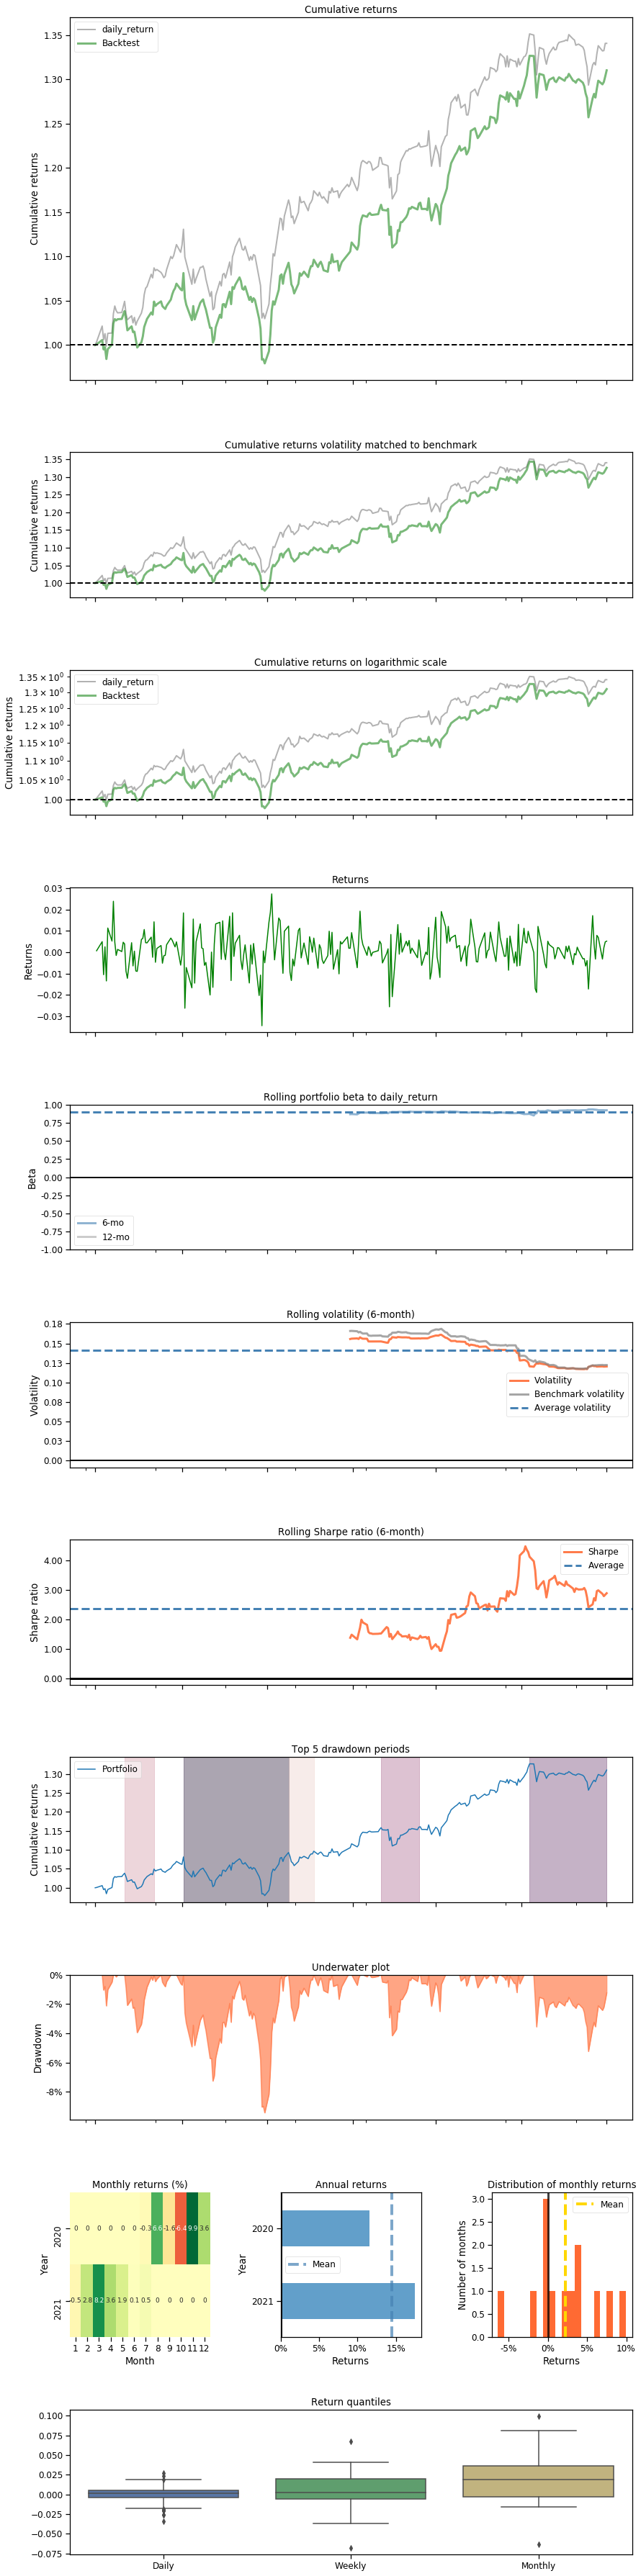

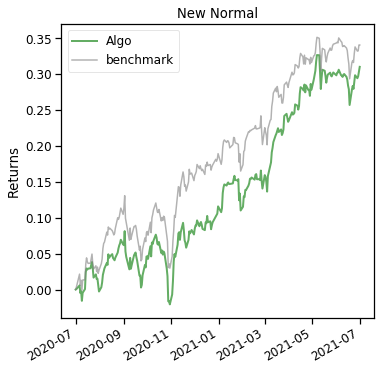

In [60]:
print("==============Compare to DJI===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

backtest_plot(
    account_value=df_account_value,
    baseline_ticker='^DJI',
    baseline_start=df_account_value.loc[0,'date'],
    baseline_end=df_account_value.loc[len(df_account_value)-1,'date']
)